# Modelling

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import shap
import joblib

# Preparing our dataset

In [2]:
# Load our data (cleaning and outlier techniques applied)
df = pd.read_csv('churn_cleaned_df.csv')
df.head()

,customerID,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,Contract_Two year,InternetService_DSL,InternetService_Fiber optic,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_outlier,MonthlyCharges_outlier,TotalCharges_outlier
0,7590-VHVEG,0,1,0,0.000000,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
1,5575-GNVDE,0,0,0,0.464789,1,0,1,0,1,...,0,1,0,0,0,0,1,0,0,0
2,3668-QPYBK,0,0,0,0.014085,1,0,1,1,0,...,0,1,0,0,0,0,1,0,0,0
3,7795-CFOCW,0,0,0,0.619718,0,0,1,0,1,...,0,1,0,1,0,0,0,0,0,0
4,9237-HQITU,0,0,0,0.014085,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [3]:
# Drop the column and save it to a variable
#   If you need to bring the column back later, simply reassign it to the DataFrame
#   df['customerID'] = customer_id
customer_id = df.pop('customerID')

# Separate the target variable (Churn) from the rest of the dataset
X = df.drop('Churn', axis=1)
y = df['Churn']

# Balancing our training dataset
Given that our dataset is imbalanced (26.5% of the users churn), we need to correct this effect in order to obtain the desired results with the model.

SMOTE (Synthetic Minority Over-sampling Technique) is a popular algorithm used for data upsampling in machine learning. It creates synthetic samples of the minority class by creating new observations that are similar to existing observations, thus balancing the class distribution. We can perform data upsampling using SMOTE in Python with the imbalanced-learn library.

Balancing your dataset with SMOTE should be performed on the training set only. This way, you ensure that your model learns from a balanced representation of the data while preserving the integrity and independence of the test and validation datasets. In other words, you avoid information leakage, realistic representation of the data and an independent evaluation of the model.

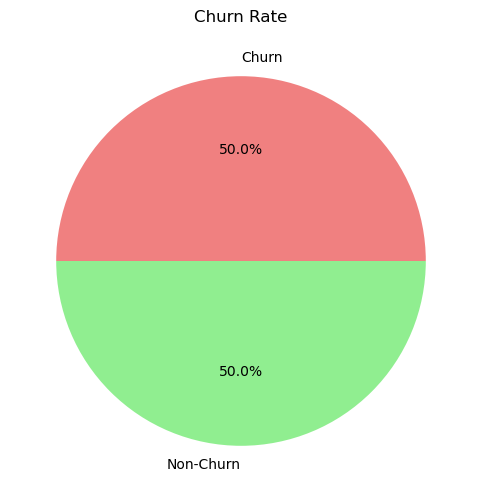

In [4]:
# Instantiate the SMOTE object
oversample = SMOTE()

# Apply SMOTE to upsample the minority class (Churn = 1) on the training set only
X_resampled_train, y_resampled_train = oversample.fit_resample(X, y)

# Combine the resampled features and target variable into a new training DataFrame
resampled_df_train = pd.concat([X_resampled_train, y_resampled_train], axis=1)

# Calculate the churn and non-churn counts
churn_count = resampled_df_train[resampled_df_train['Churn'] == 1].shape[0]
non_churn_count = resampled_df_train[resampled_df_train['Churn'] == 0].shape[0]

# Set up the plot size and title
plt.figure(figsize=(8, 6))
plt.title('Churn Rate')

# Set the colors for the pie chart sections
colors = ['lightcoral', 'lightgreen']

# Create the pie chart
plt.pie([churn_count, non_churn_count], labels=['Churn', 'Non-Churn'], autopct='%1.1f%%', colors=colors)

# Display the plot
plt.show()

# Split the dataset
Divide the dataset into training, validation, and test sets. The typical split is 70-80% for training, 10-15% for validation, and 10-15% for testing. The validation set helps in model selection and hyperparameter tuning.

Therefore, in order to obtain a split of 70% for training, 15% for validation, and 15% for testing we are setting the test dataset with a size of 15% of the original dataset, while the combined training/validation set is split with a test size of 0.1765 (approximately 15% of the combined training/validation data).

In [5]:
# Re-assign to variables 
X, y = X_resampled_train, y_resampled_train

In [6]:
# Split the data into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42, stratify=y_train_val)


# Model selection
We are exploring different options for our churn prediction, from more simple and interpretable models (i.e. Logistic Regression) to advanced models (i.e. SVM or XGBoost). We will decide which one to pick based on the validation set's performance metrics.

In [7]:
# Define a list of models including additional choices
models = [
    LogisticRegression(max_iter=1000),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(probability=True),
    XGBClassifier(),
    MLPClassifier(max_iter=1000)
]

# Iterate over the models
for model in models:
    # Train the model on the resampled training set
    model.fit(X_train, y_train)

    # Make predictions on the validation set
    y_pred_val = model.predict(X_val)

    # Calculate prediction probabilities on the validation set
    y_prob_val = model.predict_proba(X_val)[:, 1] # Probability of the positive class (churn)

    # Evaluate the model performance on the validation set
    accuracy_val = accuracy_score(y_val, y_pred_val)
    recall_val = recall_score(y_val, y_pred_val)
    precision_val = precision_score(y_val, y_pred_val)
    f1_val = f1_score(y_val, y_pred_val)
    cm_val = confusion_matrix(y_val, y_pred_val)
    tn_val, fp_val, fn_val, tp_val = cm_val.ravel()
    specificity_val = tn_val / (tn_val + fp_val)

    # Print evaluation metrics on the validation set for each model
    print(f"Model: {type(model).__name__}")
    print("Model classification report")
    print(f"Accuracy: {accuracy_val:.4f}")
    print(f"Recall: {recall_val:.4f}")
    print(f"Precision: {precision_val:.4f}")
    print(f"F1 Score: {f1_val:.4f}")
    print(f"Confusion Matrix: \n{cm_val}")
    print(f"Specificity: {specificity_val:.4f}")
    print("\n")

Model: LogisticRegression
Model classification report
Accuracy: 0.8055
Recall: 0.8481
Precision: 0.7817
F1 Score: 0.8136
Confusion Matrix: 
[[592 184]
 [118 659]]
Specificity: 0.7629


Model: DecisionTreeClassifier
Model classification report
Accuracy: 0.7508
Recall: 0.7542
Precision: 0.7494
F1 Score: 0.7518
Confusion Matrix: 
[[580 196]
 [191 586]]
Specificity: 0.7474


Model: RandomForestClassifier
Model classification report
Accuracy: 0.8236
Recall: 0.8456
Precision: 0.8101
F1 Score: 0.8275
Confusion Matrix: 
[[622 154]
 [120 657]]
Specificity: 0.8015


Model: SVC
Model classification report
Accuracy: 0.8049
Recall: 0.8571
Precision: 0.7762
F1 Score: 0.8147
Confusion Matrix: 
[[584 192]
 [111 666]]
Specificity: 0.7526


Model: XGBClassifier
Model classification report
Accuracy: 0.8274
Recall: 0.8623
Precision: 0.8063
F1 Score: 0.8333
Confusion Matrix: 
[[615 161]
 [107 670]]
Specificity: 0.7925


Model: MLPClassifier
Model classification report
Accuracy: 0.8042
Recall: 0.7426
Precis

XGBoost (Extreme Gradient Boosting) shows a slightly higher F1 score compared to other models like Logistic Regression. It is often a popular choice for many data science projects because it offers high performance and efficiency with parallel processing and tree pruning. Moreover it provides built-in regularization and handles missing values, making it versatile for regression and classification tasks. XGBoost's ensemble method yields accurate predictions, and its feature importance analysis aids in understanding data patterns

# Hyperparameter tuning
Properly tuning these hyperparameters can significantly improve the model's accuracy, prevent overfitting, and ensure optimal performance on unseen data. Without effective hyperparameter tuning, the model may underperform, leading to suboptimal results and wasted computational resources.

In [8]:
# Create an XGBoost classifier object
xgb_clf = XGBClassifier()

# Example of parameters to search. Room for improvement to find better parameters
#   in order to hypertune the model
# param_grid = {
    # 'learning_rate': [0.1, 0.01, 0.001],
    # 'max_depth': [3, 5, 7],
    # 'n_estimators': [100, 200, 300],
    # 'eval_metric': ['logloss', 'auc'],
    # 'objective': ['binary:logistic'],
    # 'booster': ['gbtree', 'gblinear', 'dart']
    # 'subsample': [0.8, 0.9, 1.0],
    # 'colsample_bytree': [0.8, 0.9, 1.0],
    # 'gamma': [0, 0.1, 0.2],
    # 'min_child_weight': [1, 3, 5],
    # 'scale_pos_weight': [1, 2, 5],
    # 'objective': ['binary:logistic'],
    # 'eval_metric': ['logloss', 'auc'],
    # 'early_stopping_rounds': [10],
    # 'tree_method': ['auto', 'exact', 'approx', 'hist'],
    # 'booster': ['gbtree', 'gblinear', 'dart']
# }


# Selected list of parameters that improve our model
param_grid = {'colsample_bytree': [0.9], 'eval_metric': ['logloss'], 'gamma': [0.2], 'learning_rate': [0.1], 'max_depth': [7], 'min_child_weight': [1], 'n_estimators': [100], 'scale_pos_weight': [2], 'subsample': [1.0]}

# Create the GridSearchCV object with the classifier, hyperparameter grid, and evaluation metric
grid_search = GridSearchCV(xgb_clf, param_grid, scoring='f1', cv=5)

# Fit the GridSearchCV on the validation data
grid_search.fit(X_val, y_val)

# Get the best hyperparameters found by GridSearchCV
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'colsample_bytree': 0.9, 'eval_metric': 'logloss', 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'scale_pos_weight': 2, 'subsample': 1.0}


# Evaluating our tuned model

In [9]:
# Create a new XGBoost classifier with the best hyperparameters
best_xgb_clf = XGBClassifier(**best_params)

# Train the classifier on the training set
best_xgb_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = best_xgb_clf.predict(X_test)

# Evaluate the model performance on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
cm_test = confusion_matrix(y_test, y_pred_test)
tn_test, fp_test, fn_test, tp_test = cm_test.ravel()
specificity_test = tn_test / (tn_test + fp_test)

# Print evaluation metrics on the test set
print("\nTest classification report")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"F1 Score: {f1_test:.4f}")
print(f"Confusion Matrix: \n{cm_test}")
print(f"Specificity: {specificity_test:.4f}")


Test classification report
Accuracy: 0.8210
Recall: 0.9175
Precision: 0.7689
F1 Score: 0.8367
Confusion Matrix: 
[[563 214]
 [ 64 712]]
Specificity: 0.7246


#### Summary

After tuning our XGBoost model we can determine that:
- Our model achieved an accuracy of 82.10% on the test data, meaning that 82.10% of the customers were correctly classified as churn or non-churn users.

- Recall answers the question: "Out of all the users who actually churned, how many did the model correctly identify?". A high recall indicates that the model is effective at identifying most of the users who are likely to churn. This is crucial for the business because it helps it take proactive measures to retain these users, preventing potential revenue loss. Our hypertuned model improved recall, reaching 91.75%.

- Precision answers the question: "Out of all the users predicted to churn, how many of them actually did churn?". A high precision indicates that when the model predicts a user will churn, it's more likely to be correct. This is important because it helps businesses avoid unnecessarily reaching out to users who are not actually going to churn, which can save resources and prevent negative customer experiences. Precision lowered compared to our initial model from 80.63% to 76.89%, as a trade-off for the recall increase.

- The F1 score, which balances precision and recall, stood at 83.67%. This shows that our model has a good balance between accurately predicting churn and identifying most of the actual churners. 

- However specificity decreased compared to our initial model, showing that our hypertuned model shows a worse performance identifying non-churn users.

#### Conclusion
Hypertuning the model did not lead to a significant improvement in the F1 score, but it did result in a notable enhancement of the recall by 6.4%. Moreover, high recall shows confidence on detecting positively churned users, which is the primary goal of the project - enabling proactive measures to retain those customers (i.e. more aggresive discounts, additional products...)

In [10]:
# Create dataframe with test labels and our predictions
final_df = pd.DataFrame({'prediction_churn': y_pred_test, 'is_churn': y_test})

# Calculate percentage of churned users we predicted to be churn
#  We arrive at the same figure as Recall
final_df[(final_df['is_churn']==1) & (final_df['prediction_churn']==1)].shape[0] / final_df[final_df['is_churn']==1].shape[0]

0.9175257731958762

# Model interpretability
Model interpretability is important for building trust between stakeholders, understanding model behavior, identifying and resolving errors, ensuring regulatory compliance, facilitating collaboration, and guiding model improvement. It plays a critical role in the practical application of machine learning models and enables their effective and responsible use in real-world scenarios.

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


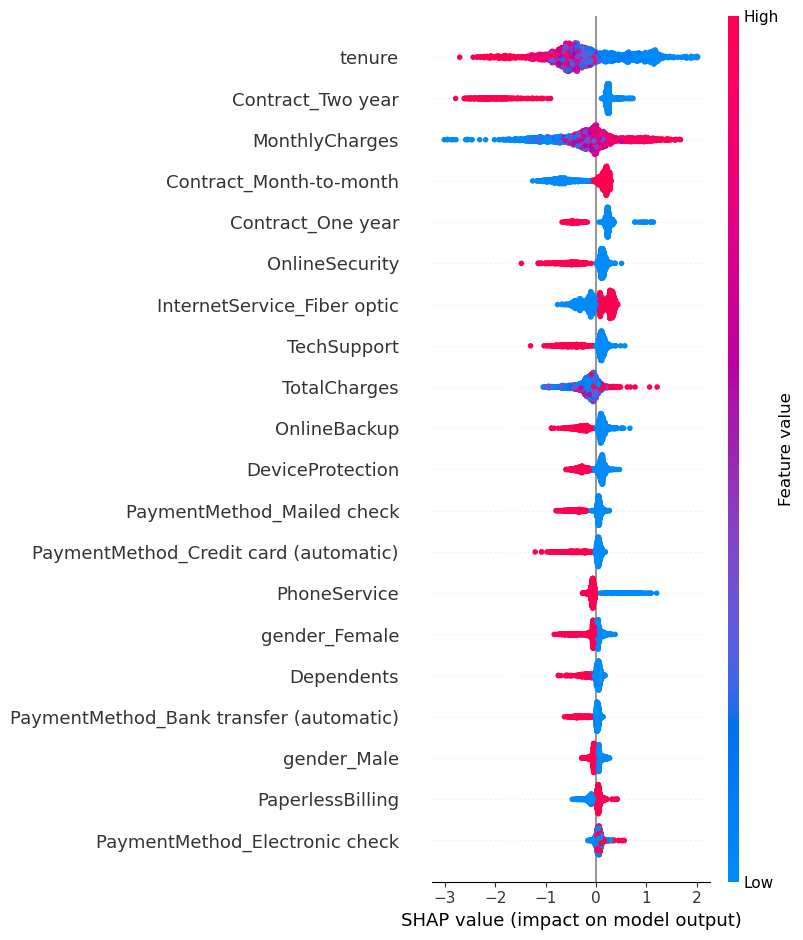

In [11]:
# Create an explainer object by providing our XGBoost model,
explainer = shap.Explainer(best_xgb_clf)

# Calculate SHAP value using our testing set
shap_values = explainer(X_test)

# Create a summary plot
shap.summary_plot(shap_values, X_test)

MonthlyCharges being blue on the left and red on the right, it means that low values of MonthlyCharges have a negative impact on the predicted target value, whereas high values of MonthlyCharges have a positive impact to the output.

Similarly, with tenure being blue on the right and red on the left, it means that low values of tenure have a positive impact on the predicted target value, whereas high values of tenure have a negative impact.

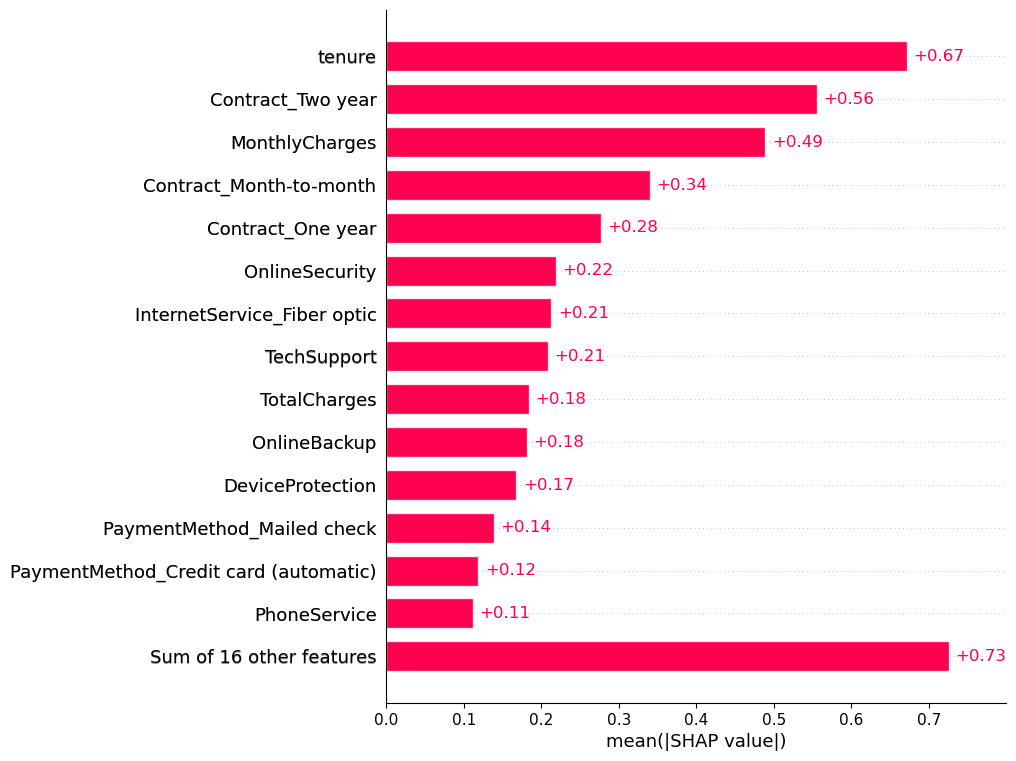

In [12]:
shap.plots.bar(shap_values, max_display=15)

In this case, the output shows that Contract_Two year is the most important feature, with a SHAP value of +0.45%. This means that changes in the Contract_Two year feature have the largest impact on the model's predictions. Specifically, This indicates that customers who are on a two-year contract are less likely to churn compared to those on a one-year or month-to-month contract.

The MonthlyCharges feature is the second most important feature with a SHAP value of +0.45% too. An increase in MonthlyCharges is associated with an increase in the likelihood of churn, while an decrease in MonthlyCharges is associated with a decrease in the likelihood of churn.

Overall, these results suggest that pricing plans, contract terms and how long are customers engaged with the company (tenure) are important factors in predicting customer churn. The model may be used to optimize pricing plans and contract terms to minimize churn and maximize customer retention.

In [13]:
# Forceplot for first observation. This shows the impact of each feature towards 
#   a specific customer's probability to churn
shap.initjs()
shap.plots.force(shap_values[38]) 

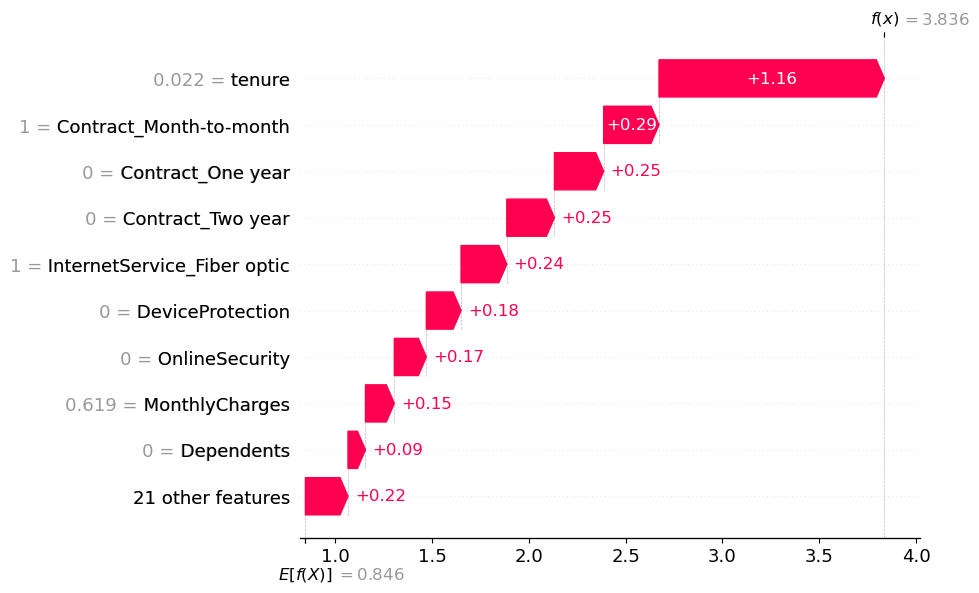

In [14]:
# Plot the SHAP values for the same user in different format
shap.plots.waterfall(shap_values[38])

# Storing the trained model
Storing the model locally provides convenience, reproducibility, deployment flexibility, and collaboration capabilities. It allows you to leverage the trained model for making predictions, sharing, and working on further improvements without the need for retraining or relying on the original training data.

We will be using `joblib`, a Python library that provides tools for efficient and easy serialization (saving) and deserialization (loading) of Python objects. It is primarily used for handling large data structures, such as NumPy arrays or scikit-learn models, in a way that minimizes memory usage and serialization time. It provides improved efficiency, memory management, and parallel processing capabilities compared to the standard pickle module.

In [15]:
# Save the trained model to a file
model_dump = 'churn_prediction_xgboost_model.joblib'
joblib.dump(model, model_dump)

['churn_prediction_xgboost_model.joblib']

In [16]:
# Load the saved model from file
loaded_model = joblib.load('churn_prediction_xgboost_model.joblib')

# Read one row of data for demonstration purposes
X_new = pd.read_csv('churn_cleaned_df.csv').tail(1)
X_new = X_new.drop(['Churn', 'customerID'], axis=1)

# Use the loaded model for predictions
y_pred = loaded_model.predict(X_new)

# Print results
y_pred

array([0])

The prediction for that user is 0, meaninig that the client is expected not to churn.